In [2]:
import keras.backend as K
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn.neighbors as skn
from random import randrange

2023-07-02 11:39:27.022128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Importing and preparing the dataset

In [3]:
# splitting data in train and set
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# input images dimensions
img_rows, img_cols = 28, 28

# preparing images
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols)
    input_shape = (img_rows, img_cols)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

np.savez_compressed('mnist.npz', x_train, y_train, x_test, y_test)

In [5]:
arc = np.load('mnist.npz')

x_train = arc['arr_0']
y_train = arc['arr_1']
x_test  = arc['arr_2']
y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


Just to try, we print one of the images (the number 15)

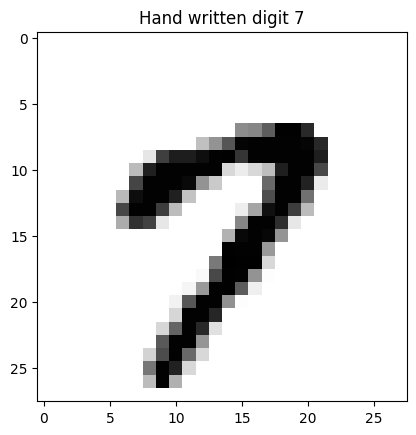

In [6]:
N=15

plt.imshow(x_train[N], cmap='gray_r')
_ = plt.title('Hand written digit '+str(y_train[N]))

## Assignment one

In the following cell we define the three different distance functions

In [7]:
def dist_infty(a, b):
    return np.max(np.fabs(a - b))

def dist_1(a, b):
    return np.sum(np.fabs(a - b))

# here we removed the absolute value to enhance performance
def dist_2(a, b):
    return math.sqrt(np.sum((a - b)**2))

We now time the three functions we defined

In [8]:
# we pick two random images from the training set

test1 = x_train[randrange(x_train.shape[0])]
test2 = x_train[randrange(x_train.shape[0])]

In [9]:
%%timeit
dist_infty(test1, test2)

12 µs ± 424 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [10]:
%%timeit
dist_1(test1, test2)

13.2 µs ± 474 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [11]:
%%timeit
dist_2(test1, test2)

13.3 µs ± 301 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


As we can see, the three distance functions have all very similar performance.

## Assignment two

We now compute the distance among the first `N` elements of the train dataset

In [12]:
# defining the function to compute distance matrix

def dist_mat(N, dist):

    # initializing matrix of distances
    D = np.empty((N, N))

    for i in range(N):
        # computing only the non trivial distances
        D[i, i] = 0
        D[i, i+1:N] = np.array([dist(x_train[i], x_train[j]) for j in range(i+1, N)])
        D[i+1:N, i] = D[i, i+1:N]

    return D

In [13]:
# displaying some results (saved in CSV file)

N_first = 100
np.savetxt("dist_max.csv", dist_mat(N_first, dist_1), delimiter=",")

In the following cells we test the correctness of `dist_mat()` on the first 300 images of the train set and then we time the function for all the three distance functions (again on the first 300 images)

In [14]:
test = False
for dist in [dist_infty, dist_1, dist_2]:

    D_test = dist_mat(300, dist)

    # comparison
    for i in range(300):
        for j in range(300):
            if D_test[i, j] - dist(x_train[i], x_train[j]) > 1e-10:
                test = True

if test:
    print("there was an error in computing the distance matrix")
else:
    print("no error was committed in computing the distance matrix")

no error was committed in computing the distance matrix


In [15]:
%%timeit
dist_mat(300, dist_infty)

622 ms ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
dist_mat(300, dist_1)

934 ms ± 62.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
dist_mat(300, dist_2)

729 ms ± 46.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As expected, `dist_infty()` is the fastest one.

## Assignment three

We compute and plot the distance matrices for the first 100 images of the train set. In the plots, the darker the 'pixel' the higher the distance between the two corresponding images.

In [18]:
# computing the distance matrices

Dinfty = dist_mat(100, dist_infty)
D1 = dist_mat(100, dist_1)
D2 = dist_mat(100, dist_2)

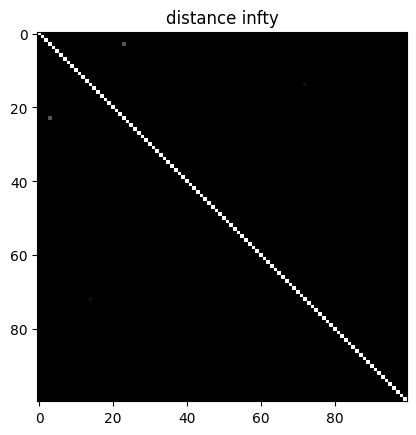

In [19]:
plt.imshow(Dinfty, cmap='gray_r')
_ = plt.title('distance infty')

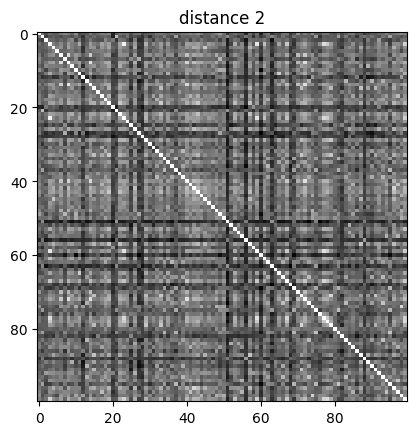

In [20]:
plt.imshow(D1, cmap='gray_r')
_ = plt.title('distance 2')

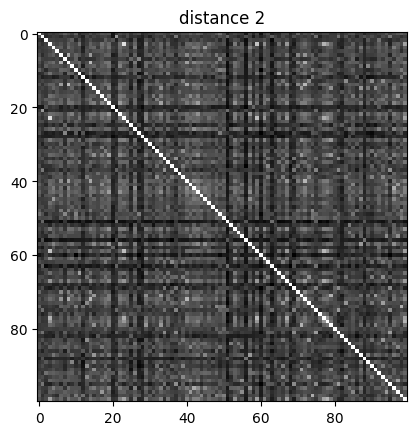

In [21]:
plt.imshow(D2, cmap='gray_r')
_ = plt.title('distance 2')

Notice that, by definition of `dist_mat()`, the plots are symmetric (since the distances we defined are symmetric by definition) and the diagonal elements are always white (since the distance between an image and itself is trivially zero).

Also notice that the `dist_infty()` functions gives maximum distance in almost all cases but when the distance is computed with the image itself. This is caused by the very nature of the distance as the maximum difference that can be found between any couple of corresponding pixels of the two images.

## Assignment four

In the following cell we define a function to compute the error on a given distance matrix

In [22]:
def comp_error(D):

    error_counter = 0
    dim = D.shape[0]

    for i in range(dim):
        
        # finding the index j of the nearest image to the i-th one
        j = np.argmin(np.concatenate((D[i, :i], D[i, i+1:])))
        if j > i:
            j += 1
        
        if y_train[i] != y_train[j]:
            error_counter += 1
    
    return error_counter/dim

In [23]:
# printing the error for all the three distance functions

print(comp_error(Dinfty))
print(comp_error(D1))
print(comp_error(D2))

0.58
0.16
0.16


We now time the function for all three distances on the previously computed distance matrices

In [24]:
%%timeit
comp_error(Dinfty)

673 µs ± 79.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
%%timeit
comp_error(D1)

811 µs ± 91.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
%%timeit
comp_error(D2)

942 µs ± 240 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


As usual, we get similar performances using the three distances.

## Assignment five

We now apply the algorithm with several N's and for all three kinds of distance, computing everytime the error

In [27]:
N_test = (100, 200, 400, 800, 1600)

error = np.empty((len(N_test), 3))   # each row a different N and each column a different distance

for i in range(len(N_test)):
    error[i, 0] = comp_error(dist_mat(N_test[i], dist_infty))
for i in range(len(N_test)):
    error[i, 1] = comp_error(dist_mat(N_test[i], dist_1))
for i in range(len(N_test)):
    error[i, 2] = comp_error(dist_mat(N_test[i], dist_2))

In [28]:
display(error)

array([[0.58    , 0.16    , 0.16    ],
       [0.52    , 0.145   , 0.135   ],
       [0.4425  , 0.15    , 0.135   ],
       [0.4     , 0.145   , 0.12875 ],
       [0.369375, 0.1025  , 0.09375 ]])

## Assignment six

We will now define a new distance function `dist_H1()`, in which we will exploit the neighboring information of the pixels. We will use the numpy function `gradient()` to compute gradients and `sum()` to compute integrals.

To compute integrals, we decided to use `sum()` instead of other ad hoc functions (like `trapz()` for instance) because, since in an image all pixels are considered to be at the same distance one from the other, the integral over it can be simply computed as the sum of all the pixels' values. Also, the `trapz()` function would compute the wrong value, since it would consider the image as if it ended in the middle of the bordering pixels, while actually all the bordering pixels' area should be considered (for more on that, see `appendix A` at the end of the notebook).

In the function, if the `comp_norm` argument is set to `True`, then the input images are normalized, otherwise they are considered to be already normalized. This is done to allow the user to speed up the process by precomputing the normalized images.

In [72]:
def dist_H1(a, b, comp_norm=True):

    # needed in the BallTree algorithm (since we must pass to it 1D arrays)
    if a.ndim == 1:
        dim = int(math.sqrt(a.shape[0]))
        a = a.reshape((dim, dim))
    if b.ndim == 1:
        dim = int(math.sqrt(b.shape[0]))
        b = b.reshape((dim, dim))

    # normalization (if needed)
    if comp_norm:
        a_norm = a / a.sum()
        b_norm = b / b.sum()
    else:
        a_norm = a
        b_norm = b
    
    # squared gradient
    grad = np.gradient(a_norm-b_norm)
    grad_2 = np.fabs(np.square(grad[0]) + np.square(grad[1]))
    
    # final integral
    sqr = np.square((a_norm-b_norm))
    integral = np.sum(grad_2 + sqr)

    return math.sqrt(integral)

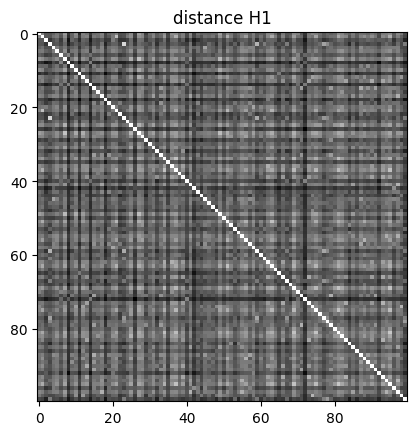

In [30]:
# displaying some distances computed with the new formula

DH1 = dist_mat(100, dist_H1)
plt.imshow(DH1, cmap='gray_r')
_ = plt.title('distance H1')

We now test the new distance function

In [31]:
# we precompute the normalized images

N_test = (100, 200, 400, 800, 1600)

error_H1 = np.empty(len(N_test))

for i in range(len(N_test)):
    error_H1[i] = comp_error(dist_mat(N_test[i], dist_H1))

In [32]:
display(error_H1)

array([0.23    , 0.175   , 0.14    , 0.12    , 0.099375])

Actually, `dist_H1()` does not seem to improve the accuracy w.r.t. the previous distances; at least as long as we are using the trivial algorithm in which we choose the image at the smallest distance.

Let's time the distance function without precomputing the normallized images ...

In [33]:
%%timeit
dist_H1(test1, test2)

112 µs ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


and precomputing them

In [34]:
test1_index = randrange(x_test.shape[0])
test2_index = randrange(x_test.shape[0])
test1 = x_train[test1_index]
test2 = x_train[test2_index]
test1_norm = x_train[test1_index] / x_train[test1_index].sum()
test2_norm = x_train[test2_index] / x_train[test2_index].sum()

In [35]:
%%timeit
dist_H1(test1_norm, test2_norm, comp_norm=False)

99.6 µs ± 3.84 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Precomputing the normalized images saves about $10-20 \mu s$, but still `dist_H1` is at least six time slower than the other three distance functions.

## Assignment seven

We now use the BallTree algorithm to make predictions. We will use the previously defined distance functions as metric for the algorithm.

In [36]:
# we need to reshape the images data to be able to use the BallTree

height = x_train.shape[0]
width = 28**2
x_train_reshaped = x_train.reshape((height, width))
x_test_reshaped = x_test.reshape((x_test.shape[0], width))

In [37]:
# defining the function to compute the error on BallTree predictions

def comp_error_bt(tree):

    error_counter = 0
    dim = x_test_reshaped.shape[0]

    # querying the tree
    response_index = tree.query(x_test_reshaped, return_distance=False)
    response = y_train[response_index]
    
    # counting wrong predictions
    for i in range(dim):
        if (response[i] != y_test[i]):
            error_counter += 1
    
    # we tried to use the following line instead of the loop but the performance was
    # not improved at all
    # error_counter = np.sum(np.array([response != y_test]))
    
    return error_counter / dim

In [51]:
tree_test = skn.BallTree(x_train_reshaped[:20, :], metric=dist_infty)

In [39]:
%%timeit
comp_error_bt(tree_test)

2.85 s ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now we compute the error committed by the BallTree algorithm using all distance functions and for different dataset sizes. Because of our resources, we were only able to train models with up to a 800 images datasets.

Also, notice that we didn't precompute the normalized images, since doing that the final accuracy decreases. And the larger the number of samples on which we train the tree the larger the gap between the result obtained precomputing the normalization and the one without doing that. For more on that see `Appendix B`.

In [92]:
N_test_bt = (100, 200, 400, 800)
error_bt = np.empty((len(N_test_bt), 4))   # each row a different N and each column a different distance

for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_infty)
    error_bt[i, 0] = comp_error_bt(tree)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_1)
    error_bt[i, 1] = comp_error_bt(tree)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_2)
    error_bt[i, 2] = comp_error_bt(tree)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_H1)
    error_bt[i, 3] = comp_error_bt(tree)

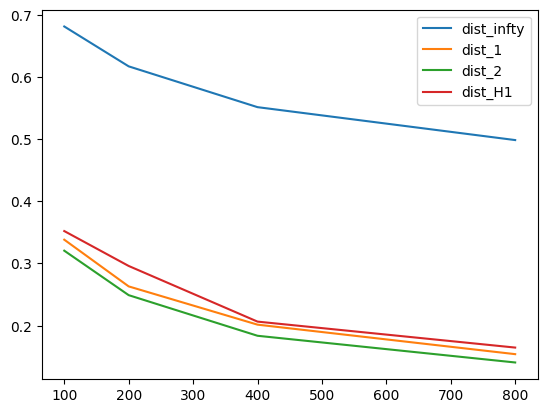

In [93]:
# plot of the error for the four distances as function of N
plt.plot(N_test_bt, error_bt[:, 0], label='dist_infty')
plt.plot(N_test_bt, error_bt[:, 1], label='dist_1')
plt.plot(N_test_bt, error_bt[:, 2], label='dist_2')
plt.plot(N_test_bt, error_bt[:, 3], label='dist_H1')
leg = plt.legend(loc='upper right')
plt.show()

As you can see from the previous plot, the H1 metric does not improve the BallTree algorithm's performance w.r.t. the previously defined metrics; at least, this is the case for models trained with up to 800 samples.

It is worth noting that the choice of the metric should also consider its computational efficiency, and that the H1 metric is by far the least efficient of all.

Until now we have used the BallTree algorithm to directly select the nearest neighbour. Now we will try to use it to return a varying number of nearest neighbours, then picking among them the digit that occurred with the highest frequency.

To do that we define a new function called `comp_error_bt_nbors()`, and then call it using 5 and 10 neighbours, for all distances and for the same dataset sizes as before. The results will be plotted as above.

Notice that, because of the computational inefficiency of the algorithm, we reduced the test set to the first 500 samples. Clearly, to compare the performance of the new algorithm with the old one we we need to recompute the error for 1 closest neighbour as well.

In [121]:
# defining the function to compute the error on BallTree predictions choosing the most frequently
# occurrent label among the nbors closest neighbours

def comp_error_bt_nbors(tree, nbors):

    error_counter = 0
    
    # reducing the size of the test set
    x_test_reduced = x_test_reshaped[:500]
    y_test_reduced = y_test[:500]
    dim = x_test_reduced.shape[0]

    # querying the tree
    response_indexes = tree.query(x_test_reduced, k=nbors, return_distance=False)
    
    # selecting the digit occurring most frequently
    response = np.empty(dim)
    ies = np.arange(dim)
    for group, i in zip(response_indexes, ies):
        response[i] = np.bincount(y_train[group]).argmax()
    
    # counting wrong predictions
    for i in range(dim):
        if (response[i] != y_test_reduced[i]):
            error_counter += 1
    
    return error_counter / dim

In [122]:
# using 1 closest neighbour

error_bt_1nbors = np.empty((len(N_test_bt), 4))

for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_infty)
    error_bt_1nbors[i, 0] = comp_error_bt_nbors(tree, 1)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_1)
    error_bt_1nbors[i, 1] = comp_error_bt_nbors(tree, 1)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_2)
    error_bt_1nbors[i, 2] = comp_error_bt_nbors(tree, 1)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_H1)
    error_bt_1nbors[i, 3] = comp_error_bt_nbors(tree, 1)

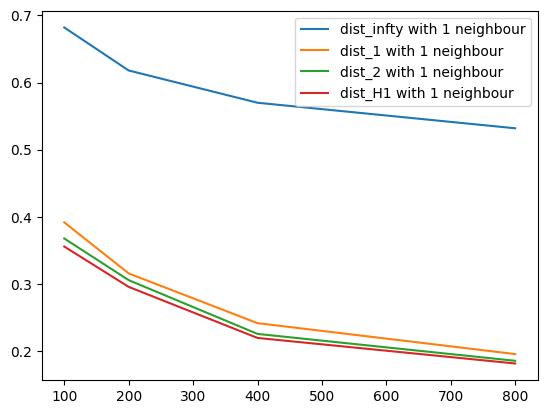

In [123]:
plt.plot(N_test_bt, error_bt_1nbors[:, 0], label='dist_infty with 1 neighbour')
plt.plot(N_test_bt, error_bt_1nbors[:, 1], label='dist_1 with 1 neighbour')
plt.plot(N_test_bt, error_bt_1nbors[:, 2], label='dist_2 with 1 neighbour')
plt.plot(N_test_bt, error_bt_1nbors[:, 3], label='dist_H1 with 1 neighbour')
leg = plt.legend(loc='upper right')
plt.show()

In [124]:
# using 5 closest neighbours

error_bt_5nbors = np.empty((len(N_test_bt), 4))

for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_infty)
    error_bt_5nbors[i, 0] = comp_error_bt_nbors(tree, 5)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_1)
    error_bt_5nbors[i, 1] = comp_error_bt_nbors(tree, 5)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_2)
    error_bt_5nbors[i, 2] = comp_error_bt_nbors(tree, 5)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_H1)
    error_bt_5nbors[i, 3] = comp_error_bt_nbors(tree, 5)

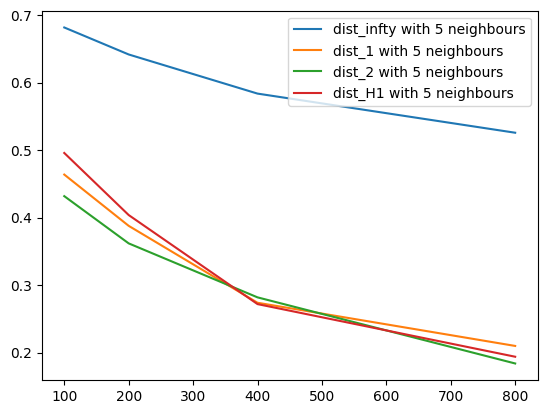

In [125]:
plt.plot(N_test_bt, error_bt_5nbors[:, 0], label='dist_infty with 5 neighbours')
plt.plot(N_test_bt, error_bt_5nbors[:, 1], label='dist_1 with 5 neighbours')
plt.plot(N_test_bt, error_bt_5nbors[:, 2], label='dist_2 with 5 neighbours')
plt.plot(N_test_bt, error_bt_5nbors[:, 3], label='dist_H1 with 5 neighbours')
leg = plt.legend(loc='upper right')
plt.show()

In [126]:
# using 10 closest neighbours

error_bt_10nbors = np.empty((len(N_test_bt), 4))

for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_infty)
    error_bt_10nbors[i, 0] = comp_error_bt_nbors(tree, 10)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_1)
    error_bt_10nbors[i, 1] = comp_error_bt_nbors(tree, 10)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_2)
    error_bt_10nbors[i, 2] = comp_error_bt_nbors(tree, 10)
for i in range(len(N_test_bt)):
    tree = skn.BallTree(x_train_reshaped[:N_test_bt[i], :], metric=dist_H1)
    error_bt_10nbors[i, 3] = comp_error_bt_nbors(tree, 10)

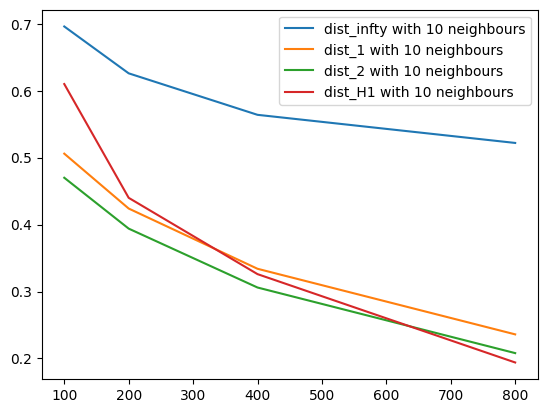

In [127]:
plt.plot(N_test_bt, error_bt_10nbors[:, 0], label='dist_infty with 10 neighbours')
plt.plot(N_test_bt, error_bt_10nbors[:, 1], label='dist_1 with 10 neighbours')
plt.plot(N_test_bt, error_bt_10nbors[:, 2], label='dist_2 with 10 neighbours')
plt.plot(N_test_bt, error_bt_10nbors[:, 3], label='dist_H1 with 10 neighbours')
leg = plt.legend(loc='upper right')
plt.show()

As we can see from the previous plots, the performance of the different metrics do not change much with the number of nearest neighbours used. The only model that seems to be sligthly improved is the one that uses H1 as metric.

## Appendix A

In the following we show why the `sum()` function is better in our case to compute the integral needed in `dist_H1()` w.r.t. to the ad hoc function `trapz()`, using a simple example.

Let's consider a 3x3 'flat' image and compute the integral using the two functions:

In [ ]:
img_example = np.full((3, 3), 0.5)

sum_int = img_example.sum()
trapz_int = np.trapz(np.trapz(img_example))

print('integral using numpy.sum(): ' + str(sum_int))
print('integral using numpy.trapz(): ' + str(trapz_int))

integral using numpy.sum():4.5
integral using numpy.trapz():2.0


The correct result is obviously the one given by `sum()`.

Actually, on larger images, the difference between the two results is probably negligible. However, `sum()` is still worth choosing, since it turns out to be faster:

In [ ]:
%%timeit
sum_int = img_example.sum()

2.25 µs ± 73.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
%%timeit
trapz_int = np.trapz(np.trapz(img_example))

34.8 µs ± 4.3 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Appendix B

Due probably to some numerical approximations, precomputing the normalized images gives a worse accuracy in BallTree using the H1 metric, especially when the number of samples on which we train the model is large.

Here we show an example with 100 samples.

In [94]:
# first we need to compute the nornmalized images for the H1 distance

norm_x = np.empty((height, width))
for i in range(len(norm_x)):
    norm_x[i] = x_train_reshaped[i] / x_train_reshaped[i].sum()

In [97]:
tree_test_1 = skn.BallTree(x_train_reshaped[:100, :], metric=dist_H1)
tree_test_1_norm = skn.BallTree(norm_x[:100, :], metric=dist_H1, comp_norm=False)

In [98]:
error_1 = comp_error_bt(tree_test_1)
error_1_norm = comp_error_bt(tree_test_1_norm)

print('error without precomputing the normalization: ' + str(error_1))
print('error precomputing the normalization: ' + str(error_1_norm))

error without precomputing the normalization: 0.3522
error precomputing the normalization: 0.3929
